# CE 295 - Energy Systems and Control
## Ursan Tchouteng Njike, SID 3033216253
## Prof. Daniel Arnold
## Due Date 03/19/2021

## Ursan_Tchouteng_Njike_HW3.ipynb

***
##  HW 3 : Optimal Economic Dispatch in Distribution Feeders with Renewables
***

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline
import pandas as pd

In [3]:
## 13 Node IEEE Test Feeder Parameters

### Node (aka Bus) Data
# l_j^P: Active power consumption [MW]
l_P = np.array([ 0, 0.2, 0, 0.4, 0.17, 0.23, 1.155, 0, 0.17, 0.843, 0, 0.17, 0.128])

# l_j^Q: Reactive power consumption [MVAr]
l_Q = np.array([ 0, 0.116, 0, 0.29, 0.125, 0.132, 0.66, 0, 0.151, 0.462, 0, 0.08, 0.086])

# l_j^S: Apparent power consumption [MVA]
l_S = np.sqrt(l_P**2 + l_Q**2)

# s_j,max: Maximal generating power [MW]
s_max = np.array([ 5, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0])

# c_j: Marginal generation cost [USD/MW]
c = np.array([ 100, 0, 0, 150, 0, 0, 0, 0, 0, 50, 0, 0, 0])

# V_min, V_max: Minimum and maximum nodal voltages [V]
v_min = 0.95
v_max = 1.05

### Edge (aka Line) Data
# r_ij: Resistance [p.u.]
r = np.array([[0, 0.007547918, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0041, 0, 0.007239685, 0, 0.007547918, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004343811, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.003773959, 0, 0, 0.004322245, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00434686, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004343157, 0.01169764],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# x_ij: Reactance [p.u.]
x = np.array([[0, 0.022173236, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0.0064, 0, 0.007336076, 0, 0.022173236, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.004401645, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0.011086618, 0, 0, 0.004433667, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.002430473, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004402952, 0.004490848],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# I_max_ij: Maximal line current [p.u.]
I_max = np.array([[0, 3.0441, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1.4178, 0, 0.9591, 0, 3.0441, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 3.1275, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0.9591, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 3.0441, 3.1275, 0, 0.9591, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1.37193, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9591, 1.2927],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

# A_ij: Adjacency matrix; A_ij = 1 if i is parent of j
A = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])# you will fill this out!

### Set Data
# List of node indices
j_idx = np.arange(13)

# \rho(j): Parent node of node j
rho = np.array([[0],[0],[1],[2],[1],[4],[1],[6],[6],[8],[6],[10],[10]]) # you will fill this out!

## Problem 1: Network Parameters

**part a)**

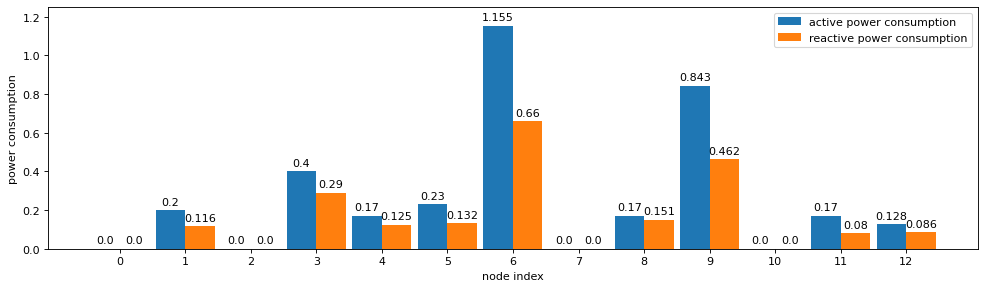

In [4]:


# Plot active and reactive power consumption
plt.figure(num=1, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
 
width = 0.45    

# create plot
bar1=plt.bar(j_idx-width/2, l_P, width, label='active power consumption')
bar2=plt.bar(j_idx+width/2, l_Q, width, label='reactive power consumption')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)


plt.legend()
plt.xticks(j_idx)
plt.xlabel('node index')
plt.ylabel('power consumption')
plt.ylim([0,1.25])

plt.show()

**Part b)**

$A=\begin{bmatrix} 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 
                   0 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
                   0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                   0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                   0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 1 & 0 & 0 \\
                   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
                   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\
                   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
                   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix} $

## Problem 2: Balancing Supply & Demand without a Network

**Part a)**<br>
* $p_i$
* $q_i$
* $s_i$

**Part b)**<br>
* $c_i^Ts_i$

**Part c)**<br>
* $s_i \le s_{i,max}$     :    apparent power generated is less or equal to the apparent power generation capacity at respective nodes
* $\sum q_i=\sum l_i^Q$   :    Total generated reactive power equals the to total consumed reactive power
* $\sum p_i=\sum l_i^P$   :    Total generated active power equals the to total consumed active power
* $\sum s_i=\sum l_i^s$   :    Total generated apparent power equals the to total consumed apparent power
* $p_i \ge 0$   :   generated active power is positive
* $q_i \ge 0$   :   generated reactive power is positive
* $\sqrt{p_i^2 + q_i^2} = s$  : the norm of the active and reactive power is the apparent power

**Part d)**<br>
No because the equality function $\sqrt{p_i^2 + q_i^2} = s$ is not affine. When we change this equality to an inequality function, we get a convex function; therefore, a convex program.

**Part e)**

In [30]:
import copy
# Assumptions:
#   - Disregard the entire network diagram
#   - Balance supply and demand, without any network considerations
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
p = Variable(13)
q = Variable(13)
s = Variable(13)

# Define objective function
objective = Minimize( c*s  )

# Define constraints
# Apparent Power Limits
constraints = [s<=s_max]

# Balance power generation with power consumption
constraints += [ sum(q)==sum(l_Q), sum(p)==sum(l_P), sum(s)==sum(l_S) ]

# Loop over each node
for jj in j_idx:
    
    # Non-negative power generation
    constraints += [p[jj]>=0, q[jj]>=0]
    
    # Compute apparent power from active & reactive power
    constraints += [norm(vstack([p[jj],q[jj]]))<=s[jj]]
    
#print(s)
    
# Define problem and solve
prob2 = Problem(objective, constraints)
prob2.solve()

# Output Results
print ("------------------- PROBLEM 2 --------------------")
print ("--------------------------------------------------")
print (prob2.status)
print ("Minimum Generating Cost : %4.2f"%(prob2.value),"USD")
print (" ")
print ("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW")
print ("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW")
print ("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW")
print (" ")
print ("Total active power   : %1.3f"%(sum(l_P).value),"MW   consumed | %1.3f"%(sum(p).value),"MW   generated")
print ("Total reactive power : %1.3f"%(sum(l_Q).value),"MVAr consumed | %1.3f"%(sum(q).value),"MVAr generated")
print ("Total apparent power : %1.3f"%(sum(l_S).value),"MVA  consumed | %1.3f"%(sum(s).value),"MVA  generated")

------------------- PROBLEM 2 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 256.25 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.907 MW | q_0 = 0.548 MW | s_0 = 1.063 MW
Node 3 [Gas]   Gen Power : p_3 = -0.000 MW | q_3 = 0.000 MW | s_3 = 0.000 MW
Node 9 [Solar] Gen Power : p_9 = 2.559 MW | q_9 = 1.554 MW | s_9 = 3.000 MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.063 MVA  generated


C:\Users\njike\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


## Problem 3: Add Line Power Flows

**Part a)**
* $p_i$
* $q_i$
* $s_i$
* $P_{ij}$
* $Q_{ij}$

**Part b)**
* $s_i \le s_{i,max}$     :    apparent power generated is less or equal to the apparent power generation capacity at respective nodes
* $\sum{s_i} = \sum{l_i^s}$   :    Total generated apparent power equals the to total consumed apparent power
* $P_{i,j} = l_j^P - p_j + \sum_{k=0}^{12}A_{j,k}P_{j,k}$ : The active power flowing on line i, j equal the net power consumed at node j plus active power delivered to adjacent nodes
* $Q_{i,j} = l_j^Q - q_j + \sum_{k=0}^{12}A_{j,k}Q_{j,k}$ : The reactive power flowing on line i, j equal the net power consumed at node j plus reactive power delivered to adjacent nodes
* $\sqrt{p_i^2 + q_i^2} \le s$  : the norm of the active and reactive power is the apparent power

**Part c)**

In [31]:
# Assumptions:
#   - Disregard L_ij, the squared magnitude of complex line current
#   - Disregard nodal voltage equation
#   - Disregard nodal voltage limits
#   - Disregard maximum line current
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
P = Variable((13, 13))
Q = Variable((13, 13))


p = Variable(13)
q = Variable(13)
s = Variable(13)


# Define objective function
objective = Minimize( c*s  ) 

# Define constraints
# Apparent Power Limits
constraints = [s<=s_max, sum(s)==sum(l_S)]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
               Q[0,0] == 0]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj]-p[jj] + sum([A[jj,k]*P[jj,k] for k in range(13)]) )]
    constraints += [Q[i,jj] == (l_Q[jj]-q[jj] + sum([A[jj,k]*Q[jj,k] for k in range(13)]) )]

    # Compute apparent power from active & reactive power
    constraints += [norm(vstack([p[jj],q[jj]]))<=s[jj]]

# Define problem and solve
prob3 = Problem(objective, constraints)
prob3.solve()

# Output Results
print ("------------------- PROBLEM 3 --------------------")
print ("--------------------------------------------------")
print (prob3.status)
print ("Minimum Generating Cost : %4.2f"%(prob3.value),"USD")
print (" ")
print ("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print ("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print ("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print (" ")
print ("Total active power   : %1.3f"%(sum(l_P).value),"MW   consumed | %1.3f"%(sum(p).value),"MW   generated")
print ("Total reactive power : %1.3f"%(sum(l_Q).value),"MVAr consumed | %1.3f"%(sum(q).value),"MVAr generated")
print ("Total apparent power : %1.3f"%(sum(l_S).value),"MVA  consumed | %1.3f"%(sum(s).value),"MVA  generated")

C:\Users\njike\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


------------------- PROBLEM 3 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 256.25 USD
 
Node 0 [Grid]  Gen Power : p_0 = 0.903 MW | q_0 = 0.548 MW | s_0 = 1.063 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = -0.000 MW | q_3 = -0.000 MW | s_3 = 0.000 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 2.563 MW | q_9 = 1.554 MW | s_9 = 3.000 MW || mu_s9 =  50 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.466 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.102 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.063 MVA  generated


The cost should be the same as that of problem 2 because P and Q tells the system how the energy flow from the generated power; therefore, balancing the generated power with the consumed power.

**Part d)**

If we increase the solar capacity by 1MW, we will save 50 USD

## Problem 4: The Complete Optimal Economic Dispatch with DistFlow Equations
**part a)**
* $p_i$
* $q_i$
* $s_i$
* $P_{ij}$
* $Q_{ij}$

**part b)**
* $i = \rho(j)$ :  node i is the parent node of node j
* $s_i \le s_{i,max}$     :    apparent power generated is less or equal to the apparent power generation capacity at respective nodes

* $P_{i,j} = l_j^P - p_j + r_{i,j}L_{i,j} + \sum_{k=0}^{12}A_{j,k}P_{j,k}$ : The active power flowing on line i, j equal the net power consumed at node j plus active power delivered to adjacent nodes plus the power dissipated on line i, j 
* $Q_{i,j} = l_j^Q - q_j + r_{i,j}L_{i,j} + \sum_{k=0}^{12}A_{j,k}Q_{j,k}$ : The reactive power flowing on line i, j equal the net power consumed at node j plus reactive power delivered to adjacent nodes plus the power dissipated on line i, j
* $V_{j} = V_i + (r_{i,j}^2 + x_{i,j}^2)L_{i,j} - 2(r_{i,j}P_{i,j} + x_{i,j}Q_{i,j})$ : The voltage squared at node j equals the parent node voltage squared plus the active current squared flowing on line i, j multipled by the norm squared of the resistance and reactance minus the sum of the product of the active power and resistance, and the product of the reactance and reactive power times 2 
* $L_{i,j} = \frac{P_{i,j}^2+Q_{i,j}^2}{V_{j}}$ : The current squared equals the norm squared of the active and reactive power divided by the voltage squared
* $\sqrt{p_i^2 + q_i^2} \le s$ : The norm of the active and reactive power generated is less than the apparent power generated 

**part c)**<br>
The equality constraint $L_{i,j} = \frac{P_{i,j}^2+Q_{i,j}^2}{V_{j}}$ is not affine; therefore, the problem is not convex. if this equality constraint is changed to an inequality constraint $L_{i,j} \ge \frac{P_{i,j}^2+Q_{i,j}^2}{V_{j}}$ we get a convex function making our problem complex.

**part d)**

In [48]:


# Assumptions:
#   - Add back all previously disregarded terms and constraints
#   - Relax squared line current equation into inequality
#   - Goal is to minimize generation costs, given by c^T s

# Solve with CVXPY

# Define optimization vars
P = Variable((13, 13))
Q = Variable((13, 13))
L = Variable((13,13))
V = Variable(13)
p = Variable(13)
q = Variable(13)
s = Variable(13)

# Define objective function
objective = Minimize( c*s  ) 

# Define constraints
# Apparent Power Limits
constraints = [s<=s_max]

# Nodal voltage limits
constraints += [V>=0.98**2, V<=1.02**2 ]

# Squared line current limits
constraints += [L<=I_max**2]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj]-p[jj] + r[i,jj]*L[i,jj] + sum([A[jj,k]*P[jj,k] for k in range(13)]) )]
    constraints += [Q[i,jj] == (l_Q[jj]-q[jj] + r[i,jj]*L[i,jj] + sum([A[jj,k]*Q[jj,k] for k in range(13)]) )]

    # Nodal voltage
    constraints += [V[jj] == (V[i] + norm(vstack([r[i,jj],x[i,jj]]))**2*L[i,jj] - 2*(r[i,jj]*P[i,jj] + x[i,jj]*Q[i,jj])) ]
    
    # Squared current magnitude on lines
    constraints += [L[i,jj]>= quad_over_lin(vstack([P[i,jj],Q[i,jj]]),V[jj])]
    
    # Compute apparent power from active & reactive power
    constraints += [norm(vstack([p[jj],q[jj]]))<=s[jj]]

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print ("------------------- PROBLEM 4 --------------------")
print ("--------------------------------------------------")
print (prob4.status)
print ("Minimum Generating Cost : %4.2f"%(prob4.value),"USD")
print (" ")
print ("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print ("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print ("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print (" ")
print ("Total active power   : %1.3f"%(sum(l_P).value),"MW   consumed | %1.3f"%(sum(p).value),"MW   generated")
print ("Total reactive power : %1.3f"%(sum(l_Q).value),"MVAr consumed | %1.3f"%(sum(q).value),"MVAr generated")
print ("Total apparent power : %1.3f"%(sum(l_S).value),"MVA  consumed | %1.3f"%(sum(s).value),"MVA  generated")
print (" ")
for jj in j_idx:
    print ("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u.")

C:\Users\njike\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\njike\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\njike\anaconda3\lib\site-packages\cvxpy\expressions\express

------------------- PROBLEM 4 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 346.38 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.028 MW | q_0 = 0.167 MW | s_0 = 1.041 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.697 MW | q_3 = 0.483 MW | s_3 = 0.848 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.765 MW | q_9 = 1.476 MW | s_9 = 2.301 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.490 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.126 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.190 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.989 p.u.
Node  2 Voltage : 0.991 p.u.
Node  3 Voltage : 0.991 p.u.
Node  4 Voltage : 0.984 p.u.
Node  5 Voltage : 0.982 p.u.
Node  6 Voltage : 0.984 p.u.
Node  7 Voltage : 0.984 p.u.
Node  8 Voltage : 0.984 p.u.
Node  9 Voltage : 0.991 p.u.
Node 10 Voltage : 0.982 p.u.
Node 11 Voltage : 0.981 p.u.
Node 12

In [49]:
#part f

constraints[1].dual_value

array([3.78816762e-08, 8.13103395e-08, 6.37515269e-08, 6.37532877e-08,
       1.58035630e-07, 1.95066712e-07, 1.75464168e-07, 1.73970000e-07,
       1.75476501e-07, 7.09566510e-08, 2.80223481e-07, 3.60940764e-07,
       1.44675024e+03])

In [46]:
#part e

constraints[3].dual_value

array([[1.29378708e+02, 1.64437781e-10, 5.94209142e-10, 5.94209142e-10,
        5.94209142e-10, 5.94209142e-10, 5.94209142e-10, 5.94209142e-10,
        5.94209142e-10, 5.94209142e-10, 5.94209142e-10, 5.94209142e-10,
        5.94209142e-10],
       [5.94209142e-10, 5.94209142e-10, 3.32652984e-10, 5.94209142e-10,
        9.53322833e-10, 5.94209142e-10, 1.68764606e-10, 5.94209142e-10,
        5.94209142e-10, 5.94209142e-10, 5.94209142e-10, 5.94209142e-10,
        5.94209142e-10],
       [5.94209142e-10, 5.94209142e-10, 5.94209142e-10, 5.01522869e-10,
        5.94209142e-10, 5.94209142e-10, 5.94209142e-10, 5.94209142e-10,
        5.94209142e-10, 5.94209142e-10, 5.94209142e-10, 5.94209142e-10,
        5.94209142e-10],
       [5.94209142e-10, 5.94209142e-10, 5.94209142e-10, 5.94209142e-10,
        5.94209142e-10, 5.94209142e-10, 5.94209142e-10, 5.94209142e-10,
        5.94209142e-10, 5.94209142e-10, 5.94209142e-10, 5.94209142e-10,
        5.94209142e-10],
       [5.94209142e-10, 5.94209142e-

**Part e)**
The line current constraint is active at node 0 for $0.95^2 \le V \le 1.05^2$
The optimal 
Minimum Generating Cost : 296.38 USD

|                                             |          |              |                 |  
| -------------------------------------------:|---------:|-------------:|----------------:|
|Node 0 [Grid]  Gen Power : p_0 = 1.553 MW | q_0 = 0.943 MW | s_0 = 1.817 MW | mu_s0 =   0 USD/MW|
|Node 3 [Gas]   Gen Power : p_3 = 0.000 MW | q_3 = -0.000 MW | s_3 = -0.000 MW | mu_s4 =   0 USD/MW|
|Node 9 [Solar] Gen Power : p_9 = 1.955 MW | q_9 = 1.201 MW | s_9 = 2.294 MW | mu_s9 =   0 USD/MW|

|                                             |          |  
| -------------------------------------------:|---------:|
|Total active power   : 3.466 MW   consumed | 3.508 MW   generated|
|Total reactive power : 2.102 MVAr consumed | 2.144 MVAr generated|
|Total apparent power : 4.063 MVA  consumed | 4.111 MVA  generated|

**Part f)**

This is because further increasing the constraint of v to $V \ge 0.98$ activated the constraint at node 12; therefore, it had an effect on the minimum generating cost.

optimal
Minimum Generating Cost : 346.38 USD

|                                             |          |              |                 |  
| -------------------------------------------:|---------:|-------------:|----------------:|
Node 0 [Grid]  Gen Power : p_0 = 1.028 MW | q_0 = 0.167 MW | s_0 = 1.041 MW | mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.697 MW | q_3 = 0.483 MW | s_3 = 0.848 MW | mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.765 MW | q_9 = 1.476 MW | s_9 = 2.301 MW | mu_s9 =   0 USD/MW

|                                             |          |  
| -------------------------------------------:|---------:|
Total active power   : 3.466 MW   consumed | 3.490 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.126 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.190 MVA  generated

In [24]:
constraints[1].dual_value

array([3.78816762e-08, 8.13103395e-08, 6.37515269e-08, 6.37532877e-08,
       1.58035630e-07, 1.95066712e-07, 1.75464168e-07, 1.73970000e-07,
       1.75476501e-07, 7.09566510e-08, 2.80223481e-07, 3.60940764e-07,
       1.44675024e+03])

## Problem 5: Robust Economic Dispatch with Renewables.

**Part a)**<br>
$\begin{bmatrix} 1 & -\sigma_a & -\sigma_b \end{bmatrix}\begin{bmatrix} s_9 \\ W_a \\ W_b \end{bmatrix} \le 0$

**Part b)**<br>
$\bar{a}=\begin{bmatrix} 1 \\ -0.5 \\ -0.5 \end{bmatrix} \space\space ; \space\space E=\begin{bmatrix} 0 & 0 & 0 \\ 0 & -0.5 & 0 \\ 0 & -0.5 & 0 \end{bmatrix}$

**Part c)**<br>
$\bar{a}^Ty + \lvert\lvert{Ey}\rvert\rvert_2 \le 0$

**Part d)**<br>
The optimization variables and constraints are the same as that of problem 4 with the inclusion of variable y and constraints below

* $\bar{a}^Ty + \lvert\lvert Ey \rvert\rvert_2 \le 0$ : representing robust inequality
* $s_9 = y_0$ : $y_0$ is the power generated by the solar panel
* $ 1 \le y_1 \le 1.5$ and $ 1 \le y_2 \le 1.5$ : The power capacity of both panels are between 1 and 1.5 MW

**Part e)**

In [29]:


# Assumptions:
#   - Assume solar generator at node 9 has uncertain power capacity
#   - Goal is to minimize generation costs, given by c^T s, in face of uncertainty

# Define optimization vars
P = Variable((13, 13))
Q = Variable((13, 13))
L = Variable((13,13))
V = Variable(13)
p = Variable(13)
q = Variable(13)
s = Variable(13)
y = Variable(3)

a = np.matrix([1, -0.5, -0.5])
E = np.matrix([[0,0,0],[0,-0.5,0],[0,0,-0.5]])

# Define objective function
objective = Minimize( c*s  ) 

# Define constraints
# Apparent Power Limits
constraints = [s<=s_max]

# Nodal voltage limits
constraints += [V>=0.95**2, V<=1.05**2 ]

# Squared line current limits
constraints += [L<=I_max**2]

# Boundary condition for power line flows
constraints += [P[0,0] == 0,
                Q[0,0] == 0]

# Boundary condition for squared line current
constraints += [L[0,0] == 0]

# Fix node 0 voltage to be 1 "per unit" (p.u.)
constraints += [V[0] == 1]

constraints += [(a*y + E*y) <= 0]
constraints += [s[9]==y[0]]
constraints += [y[1]>=1, y[1]<=1.5, y[2]>=1, y[2]<=1.5]


# Loop over each node
for jj in j_idx:
    
    # Parent node, i = \rho(j)
    i = rho[jj]
    
    # Line Power Flows
    constraints += [P[i,jj] == (l_P[jj]-p[jj] + r[i,jj]*L[i,jj] + sum([A[jj,k]*P[jj,k] for k in range(13)]) )]
    constraints += [Q[i,jj] == (l_Q[jj]-q[jj] + r[i,jj]*L[i,jj] + sum([A[jj,k]*Q[jj,k] for k in range(13)]) )]

    # Nodal voltage
    constraints += [V[jj] == (V[i] + norm(vstack([r[i,jj],x[i,jj]]))**2*L[i,jj] - 2*(r[i,jj]*P[i,jj] + x[i,jj]*Q[i,jj])) ]
    
    # Squared current magnitude on lines
    constraints += [L[i,jj]>= quad_over_lin(vstack([P[i,jj],Q[i,jj]]),V[jj])]
    
    # Compute apparent power from active & reactive power
    constraints += [norm(vstack([p[jj],q[jj]]))<=s[jj]]

# Define problem and solve
prob4 = Problem(objective, constraints)
prob4.solve()

# Output Results
print ("------------------- PROBLEM 5 --------------------")
print ("--------------------------------------------------")
print (prob4.status)
print ("Minimum Generating Cost : %4.2f"%(prob4.value),"USD")
print (" ")
print ("Node 0 [Grid]  Gen Power : p_0 = %1.3f"%(p[0].value), "MW | q_0 = %1.3f"%(q[0].value), "MW | s_0 = %1.3f"%(s[0].value),"MW || mu_s0 = %3.0f"%(constraints[0].dual_value[0]), "USD/MW")
print ("Node 3 [Gas]   Gen Power : p_3 = %1.3f"%(p[3].value), "MW | q_3 = %1.3f"%(q[3].value), "MW | s_3 = %1.3f"%(s[3].value),"MW || mu_s4 = %3.0f"%(constraints[0].dual_value[3]), "USD/MW")
print ("Node 9 [Solar] Gen Power : p_9 = %1.3f"%(p[9].value), "MW | q_9 = %1.3f"%(q[9].value), "MW | s_9 = %1.3f"%(s[9].value),"MW || mu_s9 = %3.0f"%(constraints[0].dual_value[9]), "USD/MW")
print (" ")
print ("Total active power   : %1.3f"%(sum(l_P).value),"MW   consumed | %1.3f"%(sum(p).value),"MW   generated")
print ("Total reactive power : %1.3f"%(sum(l_Q).value),"MVAr consumed | %1.3f"%(sum(q).value),"MVAr generated")
print ("Total apparent power : %1.3f"%(sum(l_S).value),"MVA  consumed | %1.3f"%(sum(s).value),"MVA  generated")
print (" ")
for jj in j_idx:
    print ("Node %2.0f"%(jj), "Voltage : %1.3f"%((V[jj].value)**0.5), "p.u.")

<ipython-input-29-884c9ad0bc78>:15: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  a = np.matrix([1, -0.5, -0.5])
<ipython-input-29-884c9ad0bc78>:16: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  E = np.matrix([[0,0,0],[0,-0.5,0],[0,0,-0.5]])
C:\Users\njike\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication

------------------- PROBLEM 5 --------------------
--------------------------------------------------
optimal
Minimum Generating Cost : 387.89 USD
 
Node 0 [Grid]  Gen Power : p_0 = 1.874 MW | q_0 = 0.597 MW | s_0 = 1.967 MW || mu_s0 =   0 USD/MW
Node 3 [Gas]   Gen Power : p_3 = 0.614 MW | q_3 = 0.473 MW | s_3 = 0.775 MW || mu_s4 =   0 USD/MW
Node 9 [Solar] Gen Power : p_9 = 1.033 MW | q_9 = 1.088 MW | s_9 = 1.500 MW || mu_s9 =   0 USD/MW
 
Total active power   : 3.466 MW   consumed | 3.521 MW   generated
Total reactive power : 2.102 MVAr consumed | 2.157 MVAr generated
Total apparent power : 4.063 MVA  consumed | 4.242 MVA  generated
 
Node  0 Voltage : 1.000 p.u.
Node  1 Voltage : 0.973 p.u.
Node  2 Voltage : 0.975 p.u.
Node  3 Voltage : 0.975 p.u.
Node  4 Voltage : 0.968 p.u.
Node  5 Voltage : 0.967 p.u.
Node  6 Voltage : 0.954 p.u.
Node  7 Voltage : 0.954 p.u.
Node  8 Voltage : 0.954 p.u.
Node  9 Voltage : 0.957 p.u.
Node 10 Voltage : 0.952 p.u.
Node 11 Voltage : 0.951 p.u.
Node 12